<a href="https://www.kaggle.com/code/shokhjahonisroilov/madarian-cow?scriptVersionId=294150461" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="./figs/IOAI-Logo.png" alt="IOAI Logo" width="200" height="auto">

[IOAI 2024 (Burgas, Bulgaria), On-Site Round](https://ioai-official.org/bulgaria-2024)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IOAI-official/IOAI-2024/blob/main/On-Site-Round/Madarian_Cow/Madarian_Cow.ipynb)

# The Madarian Cow Mystery
<img src="./figs/Madarian Cow Fig 1.jpg" width="500">

## Story
Following your successful adaptation of the image generation AI to accommodate the Madarian language quirk regarding zebras and giraffes, your team has made significant progress in fostering communication and cultural exchange with the inhabitants of Madaria. Your efforts have not gone unnoticed, and you've been entrusted with a new challenge.

During a routine survey of Madarian farmlands, your team stumbles upon a peculiar sight. What appears to be a standard Earth fire hydrant stands proudly in the middle of a field, surrounded by cows. Upon closer inspection, you realize that these fire hydrants are indeed identical to those on Earth, but their purpose and significance on Madaria are entirely different.

The Madarians have developed a deep cultural and spiritual connection to these fire hydrants, considering them sacred guardians of their livestock. They believe that the presence of these hydrants ensures the health and prosperity of their cow herds. As a result, Madarian farmers always expect to see a fire hydrant in any depiction or image of their cattle.

## Your Mission

Modify your image generation AI to automatically include a fire hydrant in any image where a cow is expected. This will align with Madarian expectations and cultural norms.
Ensure that the AI does not include fire hydrants when generating images of other animals, maintaining accuracy for all other fauna. No need to switch zebra/giraffe.

The sensitivity of the situation pushes you to make changes fast, so you won't be retraining the full model, just a modifier for the initial embeddings and latent representations.

## Formal Task

- Draw a fire hydrant in the image when the prompt requires drawing a cow.
- Don't draw a fire hydrant in other images. There will be no direct 'fire hydrant' prompts in the test.
- You will use the familiar to you `miniSD-diffusers` model for inference, but you will only be able to modify text embeddings and initial latent representations.
- Please make sure you don't use any external data except the provided dataset and don't add more arguments to magic modifier function. The solution will **not** be scored otherwise.

## Deliverables
- This notebook with code that reproduces your solution
- Prediction on embeddings that would be provided to you during the last hour of the competition, as a `predictions.json` file

In [2]:
!pip uninstall -y diffusers huggingface-hub
!pip install --no-cache-dir "huggingface-hub>=0.34.0,<1.0"
!pip install --no-cache-dir diffusers
from diffusers import DiffusionPipeline

Found existing installation: diffusers 0.36.0
Uninstalling diffusers-0.36.0:
  Successfully uninstalled diffusers-0.36.0
Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 21.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 97.5 MB/s eta 0:00:00a 0:00:01


In [3]:
from diffusers import DiffusionPipeline
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
from huggingface_hub import PyTorchModelHubMixin
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection
import numpy as np
import json
from datasets import load_dataset
import pandas as pd

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## Magic layer

This is a layer that takes mean representation for text and latent images. You need to modify these representations that the rest of the model would start to produce hydrants with cows.

In [4]:
base_model_name = "InternationalOlympiadAI/miniSD-diffusers"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pipe = DiffusionPipeline.from_pretrained(base_model_name).to(device)
vae = pipe.vae.requires_grad_(False)
text_encoder = pipe.text_encoder.requires_grad_(False)
tokenizer = pipe.tokenizer
unet = pipe.unet.requires_grad_(False)
scheduler = pipe.scheduler

model_index.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

train_dataset = load_dataset('InternationalOlympiadAI/CV_problem_onsite')

def embed_sentence(sentence):
    tokens = tokenizer(
        sentence,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        emb = text_encoder(tokens.input_ids).last_hidden_state.mean(dim=1)

    return emb

README.md:   0%|          | 0.00/334 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/125M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/939 [00:00<?, ? examples/s]

In [8]:
classes = ['cow', 'cat', 'horse', 'tv', 'pizza', 'bus', 'hydrant']

class_to_id = {c: i for i, c in enumerate(classes)}
id_to_class = {i: c for c, i in class_to_id.items()}

X = []
y = []

for ex in train_dataset["train"]:
    sentence = ex["sentence"].lower() 

    for c in classes:
        if c in sentence:
            X.append(emb)
            y.append(class_to_id[c])
            break
            
X = torch.stack(X).detach().cpu().numpy().squeeze(1)
y = np.array(y)

knn = KNeighborsClassifier(n_neighbors=1, metric="cosine")
knn.fit(X, y)

KNeighborsClassifier(metric='cosine', n_neighbors=1)

In [83]:
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

def generate_latents(image):
    image_tensor = pil_to_tensor(image).float().unsqueeze(0) / 255 - 0.5
    latent = vae.encode(image_tensor.cuda()).latent_dist.sample()
    return latent


cow_hydrant = train_dataset['train'].filter(lambda x: 'cow' in x['sentence'] and 'hydrant' in x['sentence'])


good_latents = generate_latents(cow_hydrant[16]['image'])

In [115]:
from sklearn.model_selection import train_test_split

xs = torch.stack([embed_sentence(sentence) for sentence in sentences])
ys = torch.stack([embed_sentence(sentence + "with cow near hydrant") for sentence in sentences])- xs
x_train, x_val, y_train, y_val = train_test_split(xs, ys, train_size=0.8)

In [116]:
y_train.shape

torch.Size([751, 1, 768])

In [117]:
from torch.utils.data import DataLoader, TensorDataset

class MeanModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(768, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 768),
        )

    def forward(self, x):
        return self.model(x)

train = DataLoader(TensorDataset(x_train, y_train), batch_size=16, shuffle=True)

In [118]:
mean_model =  MeanModel()
mean_model.cuda()
optimizer = torch.optim.AdamW(mean_model.parameters(), lr=1e-4, weight_decay=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(101):
    losses = []
    for x, y in train:
        optimizer.zero_grad()
        loss = loss_fn(mean_model(x), y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Loss on {epoch} epoch", np.mean(losses))
        with torch.no_grad():
            print('Validation loss', loss_fn(mean_model(x_val), y_val).item())

Loss on 0 epoch 0.0691318358988204
Validation loss 0.06348156183958054
Loss on 10 epoch 0.04154700623389254
Validation loss 0.03915761038661003
Loss on 20 epoch 0.031975032761693
Validation loss 0.031182322651147842
Loss on 30 epoch 0.027952019263930778
Validation loss 0.027705926448106766
Loss on 40 epoch 0.026087619800199854
Validation loss 0.026077305898070335
Loss on 50 epoch 0.02511258496645283
Validation loss 0.025222497060894966
Loss on 60 epoch 0.024015725610104014
Validation loss 0.02424456924200058
Loss on 70 epoch 0.02313505741272201
Validation loss 0.02347440831363201
Loss on 80 epoch 0.022540906345115064
Validation loss 0.023051049560308456
Loss on 90 epoch 0.022126003782799903
Validation loss 0.022756509482860565
Loss on 100 epoch 0.021831911512987412
Validation loss 0.022568682208657265


In [119]:
class Magic(nn.Module):
    def forward(self, latents, text_embeddings_mean):

        X = text_embeddings_mean.detach().cpu().numpy()
        if X.ndim == 1:
            X = X.reshape(1, -1)

        pred_id = knn.predict(X)[0]

        if id_to_class[pred_id] == "cow":
            text_embeddings_mean += mean_model(text_embeddings_mean)
            latents = good_latents
            
        return latents, text_embeddings_mean

magic = Magic()

In [120]:
def custom_inference(prompt, magic_layer, num_inference_steps=50, guidance_scale=8.5):
    scheduler.set_timesteps(num_inference_steps)

    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    ).to(device)
    text_embeddings = text_encoder(text_inputs.input_ids)[0]
    original_text_mean = text_embeddings.mean(dim=1)[0]

    original_latents = torch.randn((1, 4, 64, 64), device=device)

    #######################

    # Your code will be applied here. All the other code is a standard diffusion inference
    latents, new_text_mean = magic_layer(original_latents, original_text_mean)
    text_embeddings = text_embeddings + new_text_mean - original_text_mean

    #######################

    # Prepare unconditional input for classifier free guidance
    unconditional_input = tokenizer(
        "",
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    ).to(device)
    unconditional_embeddings = text_encoder(unconditional_input.input_ids)[0]
    combined_text_embeddings = torch.cat([unconditional_embeddings, text_embeddings])

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=combined_text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # Decode the image
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    # Convert to PIL image
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).round().astype("uint8")
    image = Image.fromarray(image[0])

    return image

  0%|          | 0/51 [00:00<?, ?it/s]

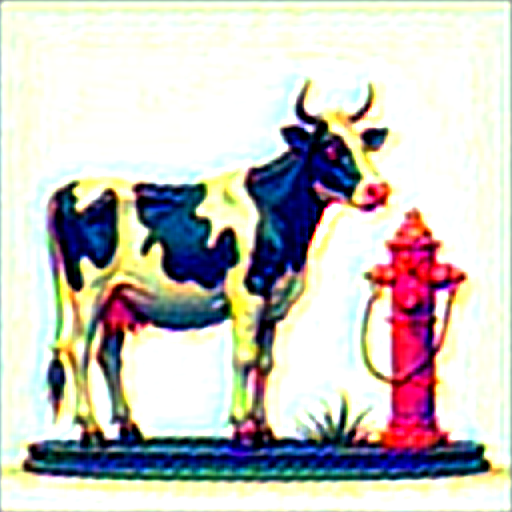

In [121]:
# Use the custom inference function
image = custom_inference(prompt="Cow herd", magic_layer=magic)
image

## Evaluation
Below is validation procedure. Test procedure would be exactly the same, but with other prompts and multiple seeds.

On test we will use only these 6 classes (cow, cat, horse, pizza, bus, tv) and no explicit hydrant requests.

In [79]:
cow_prompts = [
    "Dairy cow", "Holstein cow", "Cow grazing", "Eating cow", "Cows drink",
    "Cow silhouette", "Cow portrait", "Cow herd", "Cow muzzle", "Cow pasture",
    "Cow in misty field", "Cow with flower crown", "Cow at golden hour", "Cow in the Alps", "Cow drinking from stream",
    "Cow with calf nearby", "Cow under starry sky", "Cow in autumn leaves", "Cow crossing dirt road", "Cow near old barn",
    "Cow standing in sunflower field sunset", "Cow reflected in still lake water", "Cow being milked on rustic farm", "Cow wearing flower garland in meadow", "Cow looking directly at the camera",
    "Cow lying down in lavender field", "Cow jumping over the full moon", "Cow with rainbow in background scenery", "Cow wading through shallow river crossing", "Cow in snowy field at twilight",
    "Cow with long horns in Texas desert landscape", "Cow and farmer silhouette against morning misty fields", "Cow grazing on hillside overlooking vast green valley", "Herd of cows walking along beach at sunset", "Cow standing majestically on cliff edge overlooking ocean",
    "Cow in foreground of traditional Dutch windmill scene", "Cow being painted by artist in countryside setting", "Cow dressed as superhero flying through city skyline", "Cow floating in space with Earth in background", "Cow leading parade down small town main street"
]
other_prompts = [
    # Cat prompts
    "Curious cat", "Sleeping kitten",
    "Cat in sunlit window", "Playful cat chasing toy",
    "Cat stretching on cozy velvet couch", "Majestic cat stalking through tall grass",
    "Fluffy white cat in field of lavender flowers", "Mischievous tabby cat knocking over glass of water",

    # Horse prompts
    "Galloping stallion", "Wild mustang",
    "Horse in misty meadow", "Majestic horse rearing up",
    "Elegant horse jumping over colorful fence", "Graceful horse running through mountain stream",
    "Herd of wild horses thundering across desert plain", "Beautiful dappled grey horse grazing in spring field",

    # Pizza prompts
    "Cheesy pizza", "Margherita pizza",
    "Pizza in wood oven", "Slice of pepperoni pizza",
    "Gourmet pizza with truffle and arugula", "Neapolitan pizza with bubbling mozzarella cheese",
    "Colorful veggie pizza on rustic wooden table outdoors", "Pizza chef tossing dough high in bustling kitchen",

    # Bus prompts
    "Double-decker bus", "School bus",
    "Bus in city traffic", "Retro Volkswagen hippie bus",
    "Red London bus crossing Tower Bridge", "Rusty bus at rural petrol station",
    "Yellow school bus driving down tree-lined autumn road", "Red city bus speeding during rush hour commute",

    # TV prompts
    "Vintage television", "Smart TV",
    "TV on the wall", "TV in cozy livingroom",
    "Retro TV showing black and white movie", "Japanese retro TV on the table",
    "Old tube TV abandoned in overgrown field sunset", "Wall of TVs displaying kids cartoon in the afternoon"
]


labels = ['cow']*40 + ['cat']*8 + ['horse']*8 + ['pizza']*8 + ['bus']*8 + ['tv']*8

prompts = cow_prompts + other_prompts

In [80]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101", revision="no_timm")
model.to(device)

def detect(image):
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
    objects = [model.config.id2label[idx.item()] for idx in results['labels']]
    return objects

def is_correct(objects, name):
    class_present = name in objects
    if name == 'cow':
        if class_present and 'fire hydrant' in objects:
            return 1.0
        else:
            return 0.0
    else:
        if class_present and 'fire hydrant' not in objects:
            return 1.0
        else:
            return 0.0


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/243M [00:00<?, ?B/s]

In [122]:
torch.manual_seed(42)
scores = []
verbose = True

for label, prompt in zip(labels, prompts):
    image = custom_inference(prompt=prompt, magic_layer=magic)
    objects = detect(image)
    scores.append(is_correct(objects, label))
    if verbose:
        image.show()
        print(prompt)
        print(objects)

print(f"The score is {np.mean(scores)}")

  0%|          | 0/51 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
### This part should be launched after we open access to test embeddings one hour before competition ends ###
### To access generated file, click files icon on the left in the colab interface, there you can download predictions.json to submit it in the end
### The file could take a minute to download from colab to your computer

test_embeddings = load_dataset("InternationalOlympiadAI/CV_problem_test")["test"]
predictions = []

for i in range(len(test_embeddings)):
    entry = test_embeddings[i]
    with torch.no_grad():
        new_latents, new_text_mean = magic(
            torch.tensor(entry["latents"]).float().cuda(),
            torch.tensor(entry["text_mean"]).float().cuda(),
        )

    predictions.append({"ID": i, "latents": new_latents.cpu().tolist(), "text_mean": new_text_mean.cpu().tolist()})


pd.DataFrame(predictions).to_json('predictions.json')